This notebook is part of the supplementary material of the books "Online Machine Learning - Eine praxisorientiere Einführung",  
https://link.springer.com/book/9783658425043 and "Online Machine Learning - A Practical Guide with Examples in Python" https://link.springer.com/book/9789819970063
The contents are open source and published under the "BSD 3-Clause License".
This software is provided "as is" without warranty of any kind, either express or implied, including but not limited to implied warranties of merchantability and fitness for a particular purpose. The author or authors assume no liability for any damages or liability, whether in contract, tort, or otherwise, arising out of or in connection with the software or the use or other dealings with the software.

# Chapter 5: Evaluation und Performance Measurement

## Determination of the training and test data set in the 'spotRiver' package

In [1]:
from river import linear_model, datasets, preprocessing
from spotriver.evaluation.eval_bml import eval_oml_horizon
from spotriver.utils.data_conversion import convert_to_df
from sklearn.metrics import mean_absolute_error
metric = mean_absolute_error
model = (preprocessing.StandardScaler() |
        linear_model.LinearRegression())
dataset = datasets.TrumpApproval()
target_column = "Approve"
df = convert_to_df(dataset, target_column)
train = df[:500]
test = df[500:]
horizon = 10
df_eval, df_preds = eval_oml_horizon(
    model, train, test, target_column,
    horizon, metric=metric)

* Gnerate directory "figures" if it does not exist

In [2]:
import os
if not os.path.exists("figures"):
    os.makedirs("figures")    

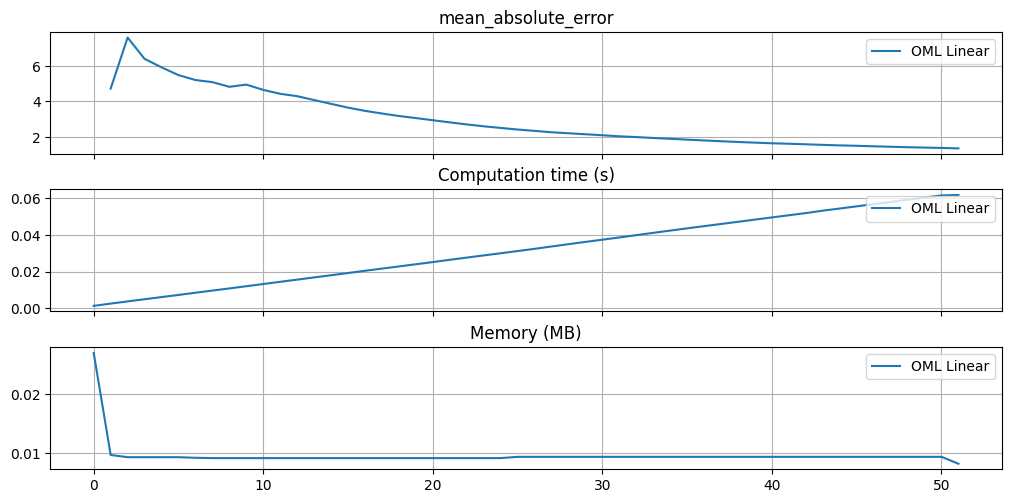

In [3]:
from spotriver.evaluation.eval_bml import plot_bml_oml_horizon_metrics
df_labels = ["OML Linear"]
plot_bml_oml_horizon_metrics(df_eval, df_labels, metric=metric, filename="./figures/ch05_fig_bml_oml_horizon_metrics.pdf")

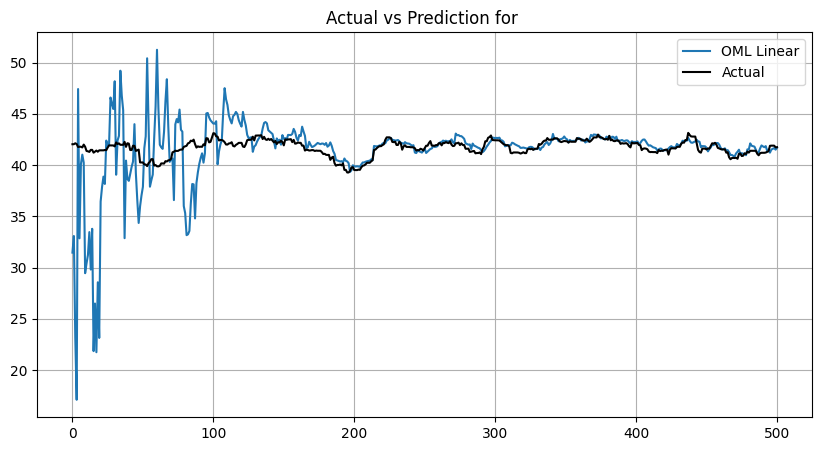

In [4]:
from spotriver.evaluation.eval_bml import plot_bml_oml_horizon_predictions
df_labels = ["OML Linear"]
plot_bml_oml_horizon_predictions(df_preds, df_labels, target_column=target_column, filename="./figures/ch05_fig_bml_oml_horizon_predictions.pdf")

## Methods for OML (River)

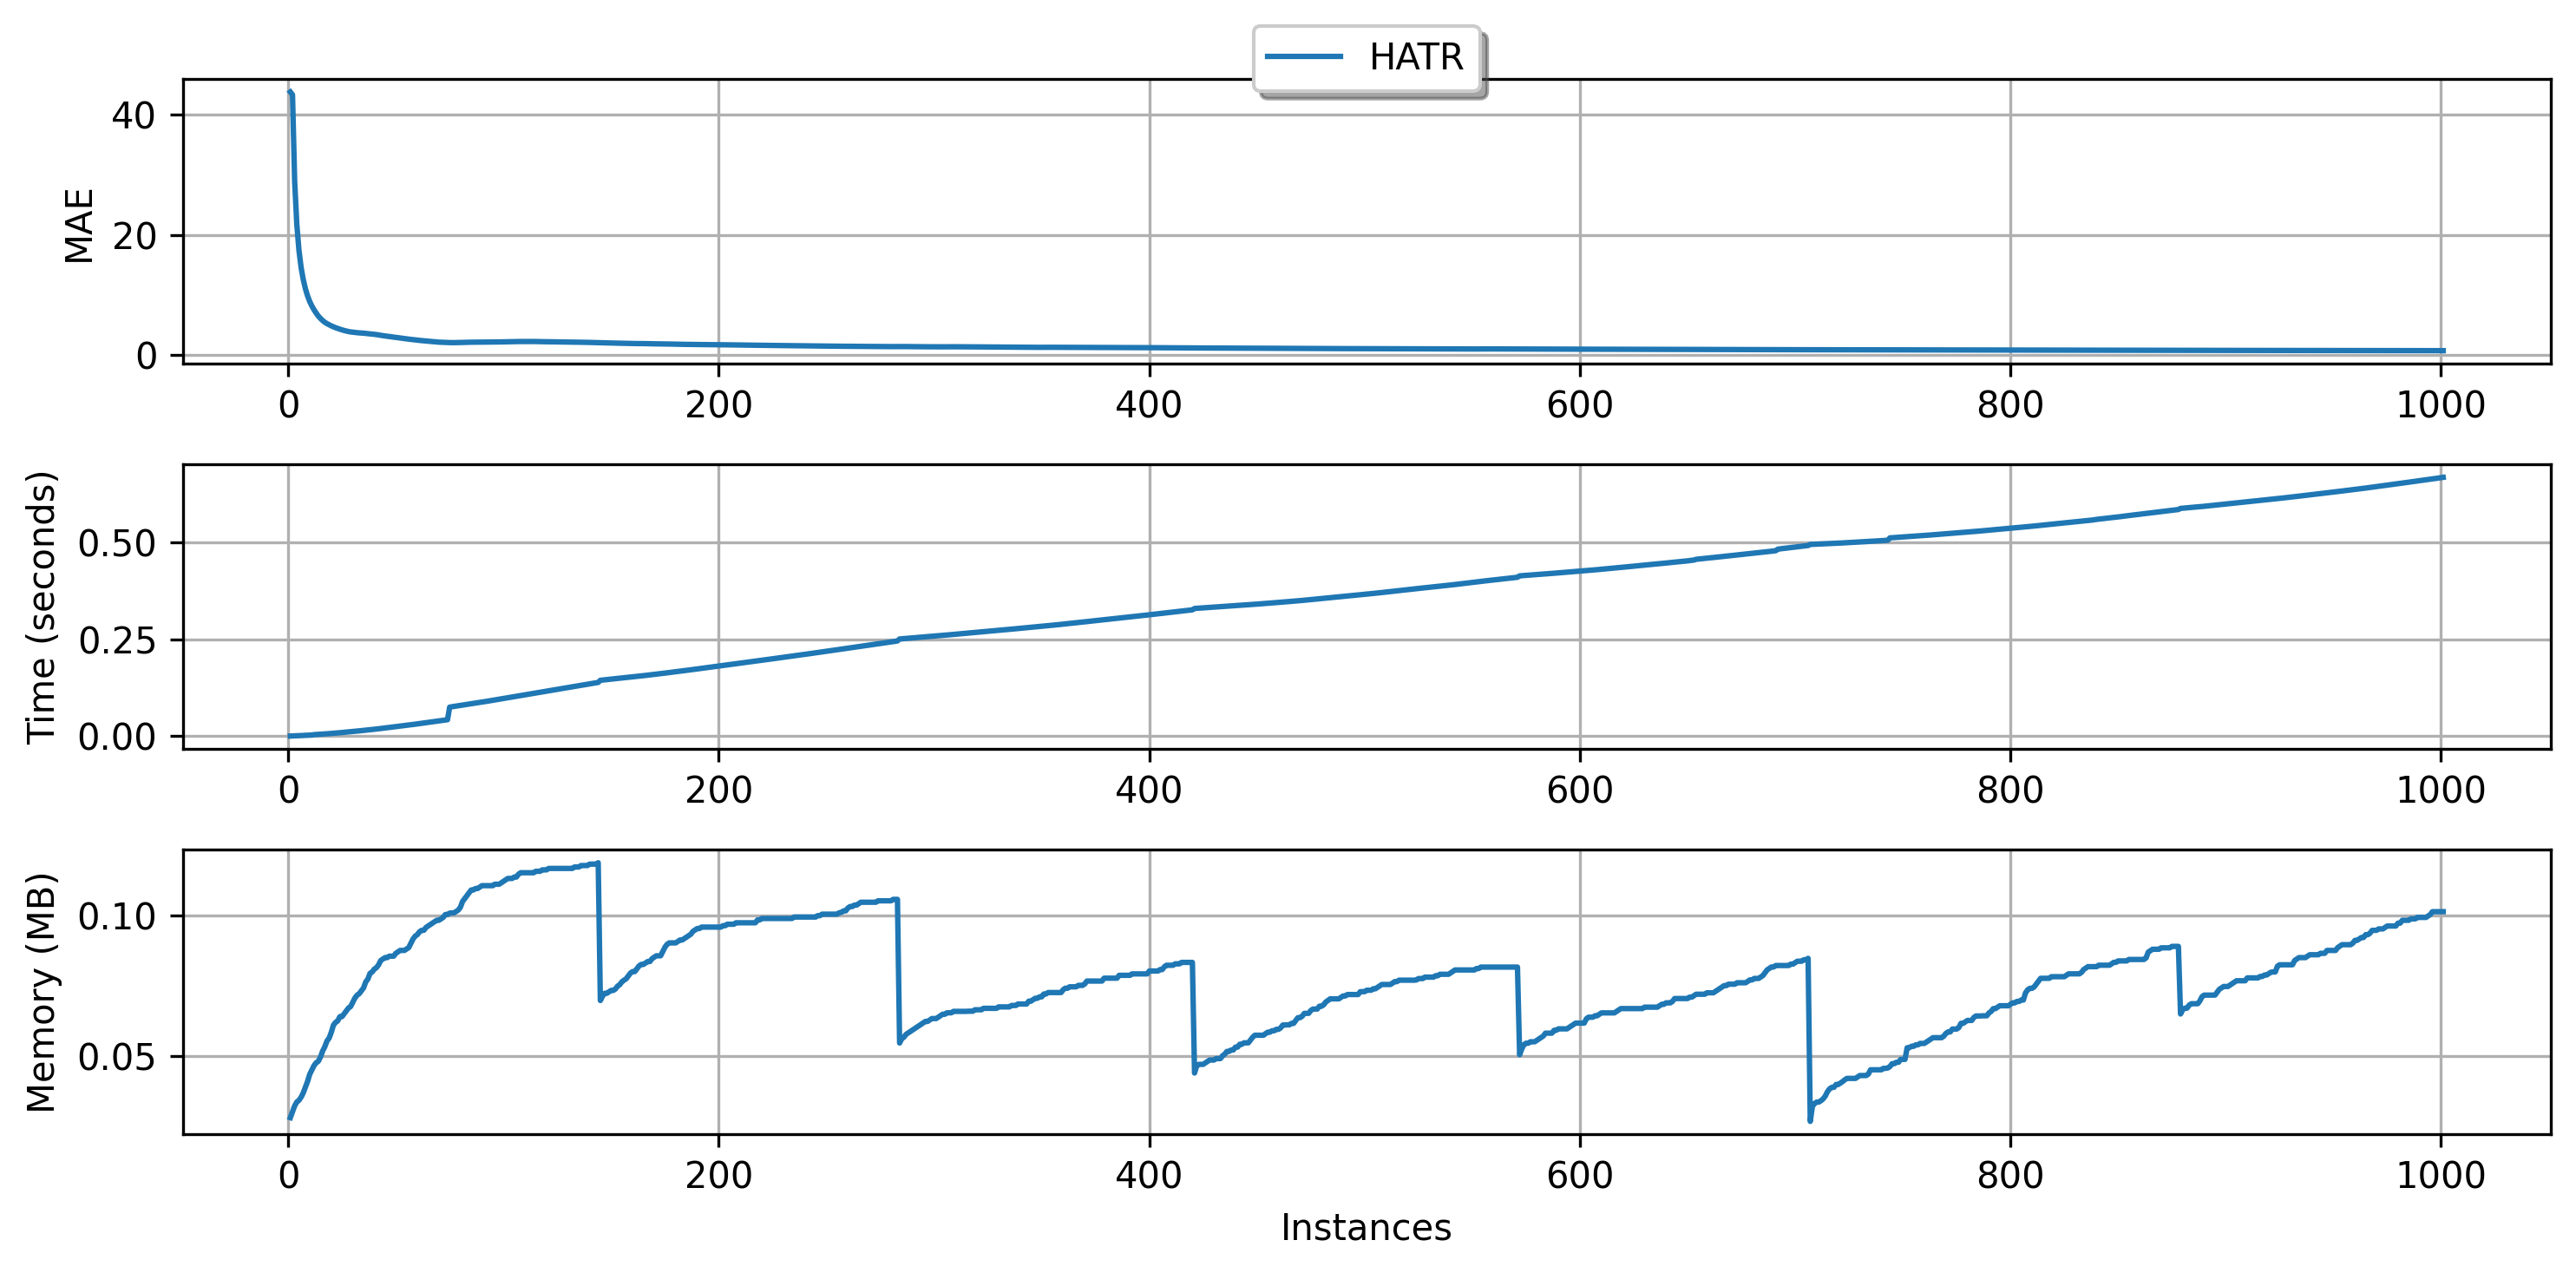

In [5]:
from river import datasets
from spotriver.evaluation.eval_oml import eval_oml_iter_progressive, plot_oml_iter_progressive
from river import metrics as river_metrics
from river import tree as river_tree
from river import preprocessing as river_preprocessing
dataset = datasets.TrumpApproval()
model =  (river_preprocessing.StandardScaler() | river_tree.HoeffdingAdaptiveTreeRegressor(seed=1))

res_num = eval_oml_iter_progressive(
    dataset = list(dataset),
    step = 1,
    metric = river_metrics.MAE(),
    models =
    {
        "HATR": model,
    }
)
plot_oml_iter_progressive(res_num, filename="./figures/ch05-eval_oml_iter_progressive.pdf")

# SEA Drift

As shown in [https://riverml.xyz/0.15.0/api/tree/HoeffdingAdaptiveTreeClassifier/](https://riverml.xyz/0.15.0/api/tree/HoeffdingAdaptiveTreeClassifier/)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from spotriver.evaluation.eval_oml import eval_oml_iter_progressive, plot_oml_iter_progressive
from spotriver.evaluation.eval_bml import eval_bml_horizon, eval_bml_landmark, eval_bml_window, eval_oml_horizon, plot_bml_oml_horizon_predictions, plot_bml_oml_horizon_metrics
from spotriver.utils.data_conversion import convert_to_df
from river import metrics as river_metrics, compose, feature_extraction, linear_model, preprocessing, stats
from river import stream as river_stream
from river import preprocessing as river_preprocessing
from river.datasets import synth
from river.tree import HoeffdingAdaptiveTreeClassifier, HoeffdingTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_regression
from sklearn import preprocessing as preprocessing_sklearn
from sklearn import tree as sklearn_tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score

In [7]:
# alternative: metric = accuracy_score
metric = f1_score
horizon = 7*24
k = 10 
n_total = int(k*100_000)
position = int(k*25_000)
width = int(n_total/250)
n_train = 1_000
a = n_train + position - 50
b = a + 50

In [8]:
gen_1 = synth.ConceptDriftStream(
        stream=synth.SEA(seed=42, variant=0),
        drift_stream=synth.SEA(seed=42, variant=1),
                               seed=1, position=position, width=width)
gen_2 = synth.ConceptDriftStream(
        stream=synth.SEA(seed=42, variant=2),
        drift_stream=synth.SEA(seed=42, variant=3),
                               seed=1, position=position, width=width)
dataset = synth.ConceptDriftStream(stream=gen_1, drift_stream=gen_2, seed=1, position=2*position, width=width)
data_dict = {key: [] for key in list(dataset.take(1))[0][0].keys()}
data_dict["y"] = []
for x, y in dataset.take(n_total):
    for key, value in x.items():
        data_dict[key].append(value)
    data_dict["y"].append(y)
df = pd.DataFrame(data_dict)
# Add column names x1 until x10 to the first 10 columns of the dataframe and the column name y to the last column
df.columns = [f"x{i}" for i in range(1, 4)] + ["y"]
df = df.apply(lambda x: x.astype(int) if x.dtype == bool else x)
train = df[:n_train]
test = df[n_train:]
target_column = "y"

* Plot the y values of the samples in the df dataframe using a sliding window of 1000 samples

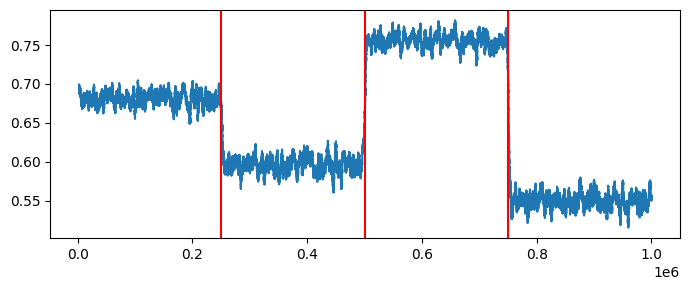

In [9]:
# plot the y values of the samples in the df dataframe using a sliding window of 1000 samples
fig = plt.figure(figsize=(7,3), tight_layout=True)
df["y"].rolling(2500).mean().plot()
plt.axvline(position, color="red")
plt.axvline(2*position, color="red")
plt.axvline(3*position, color="red")
fig.savefig("./figures/ch05_sea_drift.pdf", format='pdf', dpi=300)

plt.show()

# Evaluation, Performance Measurement


## Rolling Metrics Evaluation

### Demonstration of the "Rolling" Metric

* The method `Rolling` from the package `river` calculates a metric for the data of a sliding window $W$, where the parameter `window_size` specifies the window size $w$.
* In the example, the accuracy is calculated with a window size $w=3$:
* The first value is 0%, since `{True}` and `{False}` occur.
* The second value is 50%, since `{True, False}` are compared with `{False, False}`.
* The third value is 66%, since `{True, False, True}` are compared with `{False, False, True}`.
* The fourth value is 100%, since `{False, True, True}` are compared with `{False, True, True}`. The error in the first sample does not matter anymore.

In [10]:
from river import metrics, utils

y_true = [True, False, True, True] 
y_pred = [False, False, True, True]

metric = utils.Rolling(metrics.Accuracy(), window_size=3)

for yt, yp in zip(y_true, y_pred): 
    print(metric.update(yt, yp)) 

None
None
None
None


# Progressive Validation

## First Example: Progressive Validation (without delay)

### Using  the California Housing dataset.

* First we load the California Housing dataset.
  
* Then store the independent variables as `X` and the target variable as `y`.
* The data can then be incrementally retrieved as `dataset` via an iterator that uses the `river` method `stream.iter_pandas`.

In [11]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
california_housing = fetch_california_housing()
features = california_housing.feature_names
X = pd.DataFrame(california_housing.data, columns=features)
y = pd.Series(california_housing.target)

* Add a datetime date column to the dataframe X and the feature "moment" to the list of features

In [12]:
X["date"] = pd.date_range(start="2020-01-01", periods=len(X), freq="D")
# features.append("moment")

In [13]:
from river import stream
dataset = stream.iter_pandas(X, y)
for x, y in dataset:
    print(x, y)
    break

{'MedInc': 8.3252, 'HouseAge': 41.0, 'AveRooms': 6.984126984126984, 'AveBedrms': 1.0238095238095237, 'Population': 322.0, 'AveOccup': 2.5555555555555554, 'Latitude': 37.88, 'Longitude': -122.23, 'date': Timestamp('2020-01-01 00:00:00')} 4.526


## Model

* A linear regression model is selected as the model.
* A pipeline is set up in which the characteristics are first selected using 'Select' and then scaled before they are passed on to the linear regression model.

In [14]:
from river import compose, preprocessing, linear_model, optim
model = compose.Select(*features)
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression(optimizer=optim.SGD(0.001))

## Calculation of the MAE (Mean Absolute Errors) using progressive validation (Test-Then-Train).

* Progressive validation is the canonical method to evaluate the performance of a model. 
* It can be used to estimate how a model would have performed in a production scenario.
* The data set is transformed into a stream of questions and answers. 
  * At each step, the model is either asked to predict an observation or is either updated. 
  * The target is revealed to the model only after a certain time, which is determined by the delay parameter (`delay`). 
* By default, there is no delay, which means that the samples are processed sequentially. If there is no delay, this function performs a progressive validation (test-then-train). 
* When there is a delay, we refer to this as delayed progressive validation.
* In the first example, the MAE is displayed after `print_every=5000` steps, but is updated after each step.

In [15]:
from river import metrics, evaluate
metric = metrics.MAE()
evaluate.progressive_val_score(dataset, model, metric, print_every=5_000)

[5,000] MAE: 0.383066
[10,000] MAE: 0.412347
[15,000] MAE: 0.402725
[20,000] MAE: 0.455199
[20,639] MAE: 0.480511


MAE: 0.480511

### Second Example: Progressive Validation with Delay

* In the second example `delay=dt.timedelta(days=1)` is set and thus a delay is built in:

In [16]:
import datetime as dt

X = pd.DataFrame(california_housing.data, columns=features)
y = pd.Series(california_housing.target)



* Add a datetime date column to the dataframe X and the feature "moment" to the list of features

In [17]:


X["moment"] = pd.date_range(start="2020-01-01", periods=len(X), freq="D")
dataset = stream.iter_pandas(X, y)

evaluate.progressive_val_score(
    dataset=dataset,
    model=model.clone(),
    metric=metric,
    moment="moment",
    delay=dt.timedelta(days=1),
    print_every=5_000
)


[5,000] MAE: 0.461689
[10,000] MAE: 0.458421
[15,000] MAE: 0.447903
[20,000] MAE: 0.468081
[20,640] MAE: 0.480475


MAE: 0.480475

* Increase the delay to two weeks:

In [18]:
X = pd.DataFrame(california_housing.data, columns=features)
y = pd.Series(california_housing.target)

# add a datetime date column to the dataframe X and the feature "moment" to the list of features
X["moment"] = pd.date_range(start="2020-01-01", periods=len(X), freq="D")

dataset = stream.iter_pandas(X, y)

evaluate.progressive_val_score(
    dataset=dataset,
    model=model.clone(),
    metric=metric,
    moment='moment',
    delay=dt.timedelta(days=14),
    print_every=5_000
)

[5,000] MAE: 0.478342
[10,000] MAE: 0.480272
[15,000] MAE: 0.474482
[20,000] MAE: 0.490081
[20,640] MAE: 0.498913


MAE: 0.498913

# Drift Simulator

## Example: The synthetic SEA data set


* Implementation of the abrupt drift data stream described in [@stre01a]. 
* Each observation consists of three features. 
  * Only the first two features are relevant. 
* The target is binary and positive if the sum of the features exceeds a certain threshold. 
* There are four thresholds to choose from. 
* Concept drift can be introduced at any time during the stream by switching the threshold.

* In detail, the SEA dataset were generated as follows: 
  * First, $n=60,000$ random points were generated in a three-dimensional feature space. 
  * The features have values between 0 to 10, with only the first two features ($f_1$ and $f_2$) being relevant. 
  * The $n$ points were then divided into four blocks of $15,000$ points each. 
  * In each block, the class membership of a point is determined using a threshold $\tau_i$, where $i$ indicates the block in question.
  * Thresholds $\tau_1= 8$, $\tau_2=9$, $\tau_3=7$, and $\tau_4 = 9.5$ were chosen. 
  * In addition, the data were noisy ("We inserted about 10% class noise into each block of data.") by swapping 10% of the class memberships. 
  * Finally, a test set ($n_t = 10,000$) was determined, each composed of $2,500$ data points taken from each block.
* The python package `river` provides the function `SEA` to generate the data.

## Creating the data iterator

* First we create the iterator `dataset`, with which we create $n$ records and store them in the two lists

* `xl` and
* `yl`

as `float` values.

In [19]:
from river.datasets import synth
n = 12500 # size test data of each class. There are 4 classes.
k = 2500 # size test data set of each class.
test = dict()
train = dict()

for i in range(4): 
    xtrain = []
    ytrain = []
    xtest = []
    ytest = []

    dataset = synth.SEA(variant=i, seed=2*i)
    for x, y in dataset.take(n):
        xtrain.append( [float(a) for a in list(x.values()) ])
        ytrain.append(y)
    train[i] = [xtrain, ytrain]

    dataset = synth.SEA(variant=i, seed=2*i+1)
    for x, y in dataset.take(k):
        xtest.append( [float(a) for a in list(x.values()) ])
        ytest.append(y)
    test[i] = [xtest, ytest]
    
#print(test[0][0])
#print(test[0][1])


## The complete SEA data set

* The four partial data sets are now combined into one overall data set.

In [20]:
Xtrain = train[0][0] + train[1][0] + train[2][0] + train[3][0]
Ytrain = train[0][1] + train[1][1] + train[2][1] + train[3][1]

Xtest = test[0][0] + test[1][0] + test[2][0] + test[3][0]
Ytest = test[0][1] + test[1][1] + test[2][1] + test[3][1]

## Creating a model (decision tree)

* A decision tree is now fitted on the complete data set. 
* The first levels of the tree are visualized.

[Text(0.5, 0.875, 'x[1] <= 4.864\ngini = 0.46\nsamples = 50000\nvalue = [17887.0, 32113.0]'),
 Text(0.25, 0.625, 'x[0] <= 5.639\ngini = 0.479\nsamples = 24326\nvalue = [14631, 9695]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[0] <= 4.181\ngini = 0.172\nsamples = 13907\nvalue = [12587, 1320]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'x[1] <= 1.436\ngini = 0.315\nsamples = 10419\nvalue = [2044, 8375]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'x[0] <= 2.015\ngini = 0.221\nsamples = 25674\nvalue = [3256.0, 22418.0]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[1] <= 7.464\ngini = 0.5\nsamples = 5171\nvalue = [2548, 2623]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'x[0] <= 3.466\ngini = 0.067\nsamples = 20503\nvalue = [708, 19795]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n

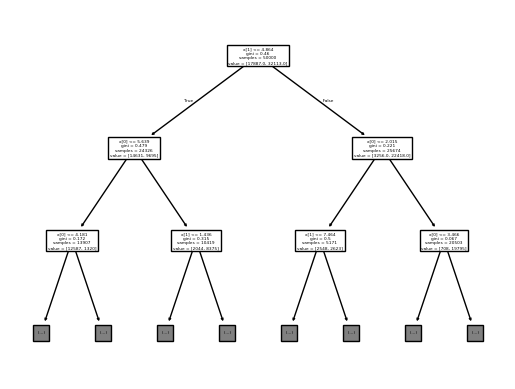

In [21]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(Xtrain, Ytrain)
tree.plot_tree(clf, max_depth=2)

## graphviz

* If the library `graphviz` is available (on operating system level and then as Python interface), appealing graphics can be generated.

In [22]:
dot_data = tree.export_graphviz(clf, out_file="sae_tree.dot", max_depth=2, filled=True)
! dot -Tpng sae_tree.dot -o sae_tree.png 

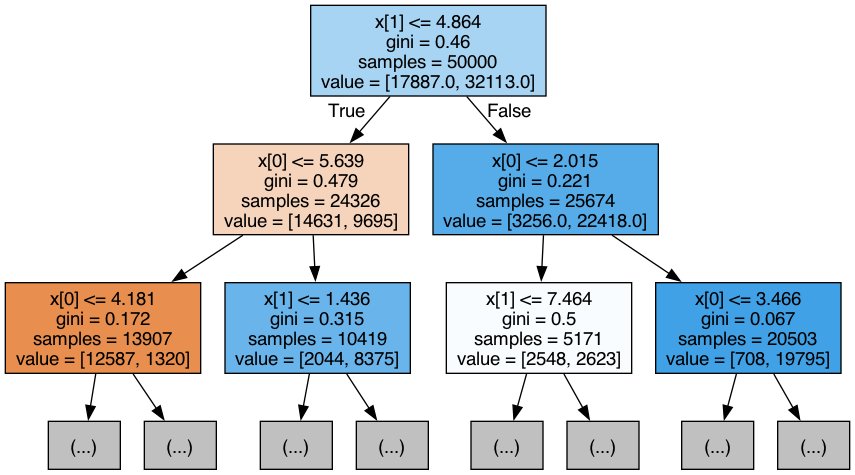

In [23]:
from IPython.display import Image
Image(filename='sae_tree.png')

## Prediction on the SEA test data

In [24]:
Ypred = clf.predict(Xtest)

Text(50.722222222222214, 0.5, 'True Label')

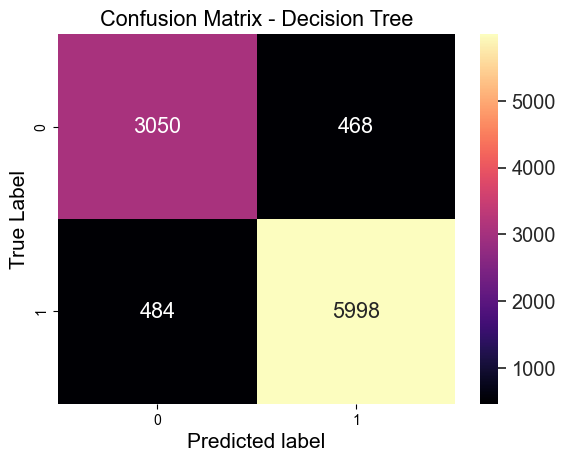

<Figure size 1000x700 with 0 Axes>

In [25]:
import pandas as pd
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(Ytest,
                                            Ypred)

matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
ax.set_title('Confusion Matrix - Decision Tree')
ax.set_xlabel("Predicted label", fontsize =15)
ax.set_ylabel("True Label", fontsize=15)

## Determining the Training and Test Data Set in the Package 'spotRiver'

* The following code illustrated the calculation of the score, memory, and time for the training and test data set in the package `spotRiver` based on the function `eval_oml_horizon()`.
* First, we use a `horizon` of 1.

In [26]:
import pandas as pd
import numpy as np
from river import linear_model
from river import preprocessing
from sklearn.metrics import mean_absolute_error
from spotriver.evaluation.eval_bml import eval_oml_horizon
model = (
        preprocessing.StandardScaler() |
        linear_model.LinearRegression(intercept_lr=.5)
    )
horizon = 1
train = pd.DataFrame({"x": np.arange(1, 11), "y": np.arange(2, 22, 2)})
test = pd.DataFrame({"x": np.arange(11, 111), "y": np.arange(22, 222, 2)})
target_column = "y"
metric = mean_absolute_error
df_eval_1, df_pred_1 = eval_oml_horizon(
    model = model,
    train = train,
    test = test,
    target_column = target_column,
    horizon = horizon,
    include_remainder = True,
    metric = metric,
    oml_grace_period = horizon,
)

In [27]:
train

,x,y
0,1,2
1,2,4
2,3,6
3,4,8
4,5,10
5,6,12
6,7,14
7,8,16
8,9,18
9,10,20


In [28]:
test

,x,y
0,11,22
1,12,24
2,13,26
3,14,28
4,15,30
...,...,...
95,106,212
96,107,214
97,108,216
98,109,218


In [29]:
df_eval_1

,Metric,Memory (MB),CompTime (s)
0,NaN,0.017886,0.000990
1,2.000000,0.006848,0.000787
2,1.880000,0.006579,0.000266
3,1.833950,0.006050,0.000263
4,1.805606,0.006050,0.000257
...,...,...,...
96,1.673556,0.006096,0.000097
97,1.673443,0.006096,0.000098
98,1.673332,0.006096,0.000098
99,1.673224,0.006096,0.000098


In [30]:
df_pred_1

,y,Prediction,Difference
0,22,20.000000,2.000000
1,24,22.120000,1.880000
2,26,24.166050,1.833950
3,28,26.194394,1.805606
4,30,28.213940,1.786060
...,...,...,...
95,212,210.326444,1.673556
96,214,212.326557,1.673443
97,216,214.326668,1.673332
98,218,216.326776,1.673224


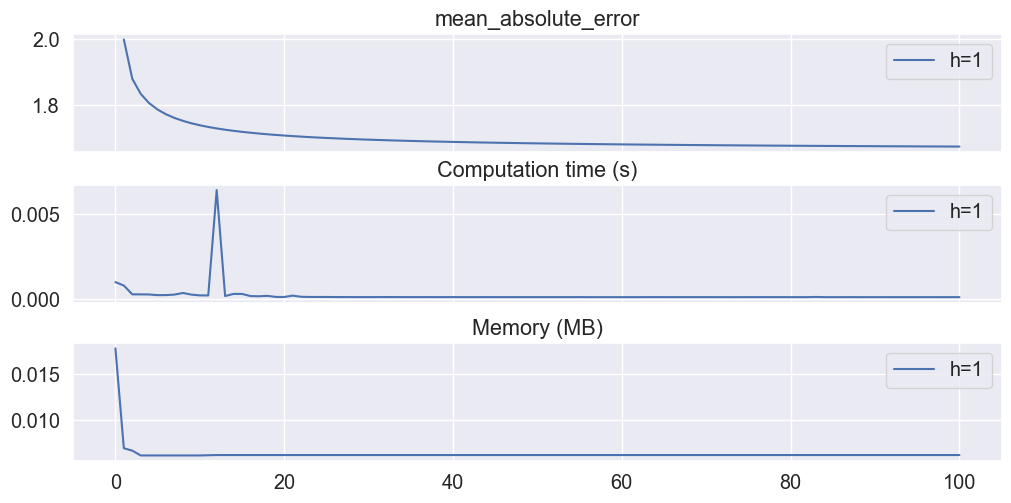

In [31]:
from spotriver.evaluation.eval_bml import plot_bml_oml_horizon_metrics, plot_bml_oml_horizon_predictions
df_labels=["h=1"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_1], log_y=False, df_labels=df_labels, metric=metric, cumulative=False, filename="./figures/ch05_fig_bml_oml_horizon_1_metrics.pdf")

### Modifying the Horizon

* `train` and `test` data remain the same, but the `horizon` is increased to 2.

In [32]:
model = (
        preprocessing.StandardScaler() |
        linear_model.LinearRegression(intercept_lr=.5)
    )
horizon = 2
train = pd.DataFrame({"x": np.arange(1, 11), "y": np.arange(2, 22, 2)})
test = pd.DataFrame({"x": np.arange(11, 111), "y": np.arange(22, 222, 2)})
target_column = "y"
metric = mean_absolute_error
df_eval_2, df_pred_2 = eval_oml_horizon(
    model = model,
    train = train,
    test = test,
    target_column = target_column,
    horizon = horizon,
    include_remainder = True,
    metric = metric,
    oml_grace_period = horizon,
)

* Since the `horizon` is increased to 2, only 50 evaluations (on the `test` data of size 100) are possible.
* After the model is initially fitted on the `train` data using a size of `oml_grace_period`, the batches from the `test` data set of size `horizon` are used for the prediction (`model.predict_one(xi)`) and the learning/updating (`model.learn_one(xi)`).

In [33]:
df_eval_2

,Metric,Memory (MB),CompTime (s)
0,NaN,0.006897,0.000212
1,1.856975,0.008536,0.000414
2,1.795833,0.008208,0.000332
3,1.766062,0.007323,0.000415
4,1.747930,0.006544,0.000349
5,1.735571,0.006363,0.000198
6,1.726540,0.006363,0.000197
7,1.719618,0.006409,0.000195
8,1.714124,0.006409,0.000215
9,1.709645,0.006409,0.000177


In [34]:
df_pred_2

,y,Prediction,Difference
0,22,20.120000,1.880000
1,24,22.166050,1.833950
2,26,24.194394,1.805606
3,28,26.213940,1.786060
4,30,28.228365,1.771635
...,...,...,...
95,212,210.326557,1.673443
96,214,212.326668,1.673332
97,216,214.326776,1.673224
98,218,216.326883,1.673117


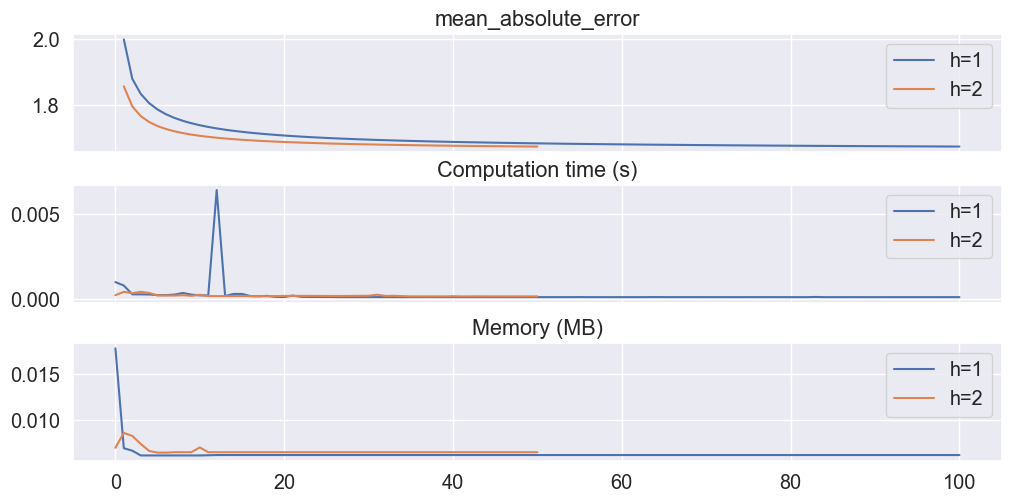

In [35]:
from spotriver.evaluation.eval_bml import plot_bml_oml_horizon_metrics
df_labels=["h=1", "h=2"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_1, df_eval_2], log_y=False, df_labels=df_labels, metric=metric, cumulative=False, filename="./figures/ch05_fig_bml_oml_horizon_1_2_metrics.pdf")

### Cumulative Metrics

* Because the `river` documentation uses a cumulative presentation of the score and computation time, this behavior can be activated by setting `cumulative=True`.

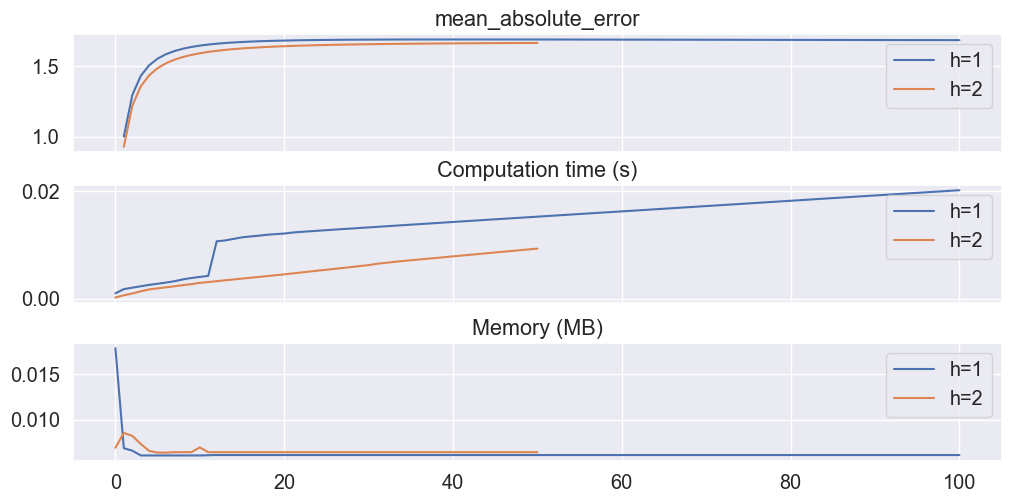

In [36]:
from spotriver.evaluation.eval_bml import plot_bml_oml_horizon_metrics, plot_bml_oml_horizon_predictions
df_labels=["h=1", "h=2"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_1, df_eval_2], log_y=False, df_labels=df_labels, metric=metric, cumulative=True, filename="./figures/ch05_fig_bml_oml_horizon_1_2_metrics_cumulative.pdf")

### The Method `plot_bml_oml_horizon_predictions`

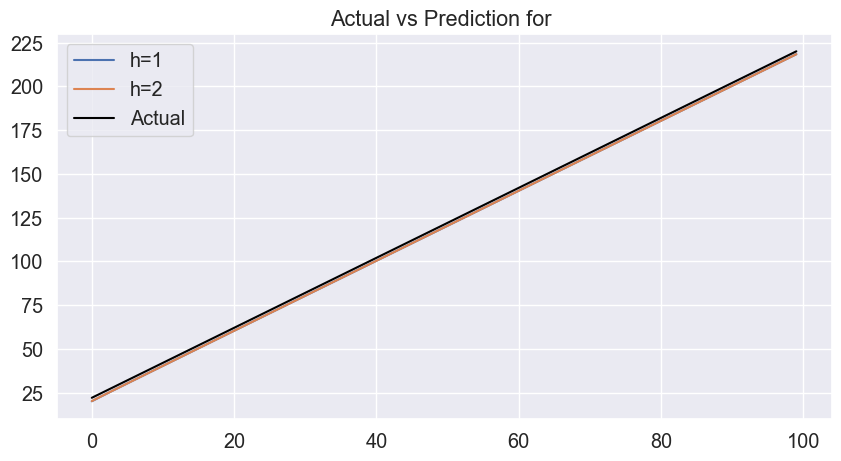

In [37]:
plot_bml_oml_horizon_predictions([df_pred_1, df_pred_2], target_column=target_column, df_labels=df_labels, filename="./figures/ch05_fig_bml_oml_horizon_1_predictions.pdf")

## Applying the Method `plot_bml_oml_horizon_predictions` to a Larger Data Set (TrumpApproval)

In [38]:
from river import linear_model, datasets, preprocessing
from spotriver.evaluation.eval_bml import eval_oml_horizon
from spotriver.utils.data_conversion import convert_to_df
from sklearn.metrics import mean_absolute_error
metric = mean_absolute_error
model = (preprocessing.StandardScaler() |
        linear_model.LinearRegression())
dataset = datasets.TrumpApproval()
target_column = "Approve"
df = convert_to_df(dataset, target_column)
train = df[:500]
test = df[500:]
horizon = 10
df_eval, df_preds = eval_oml_horizon(
    model, train, test, target_column,
    horizon, metric=metric)

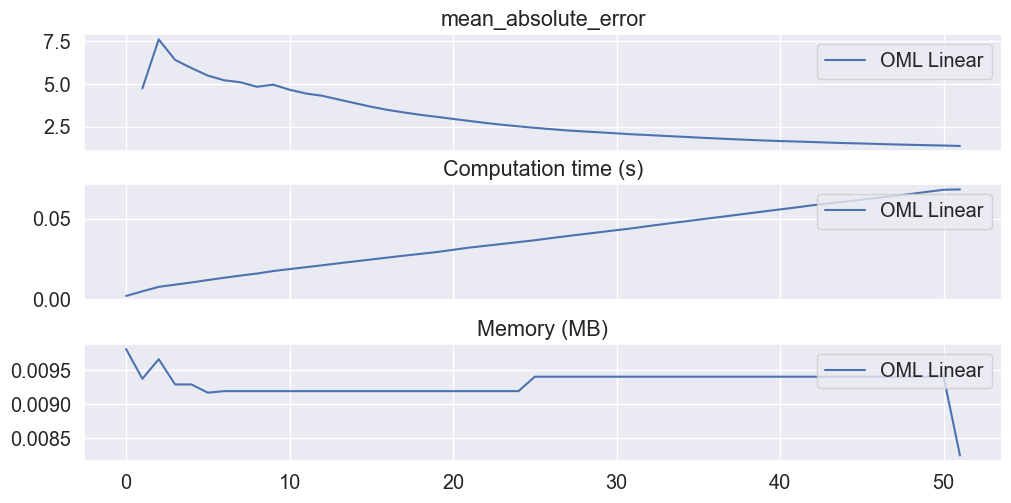

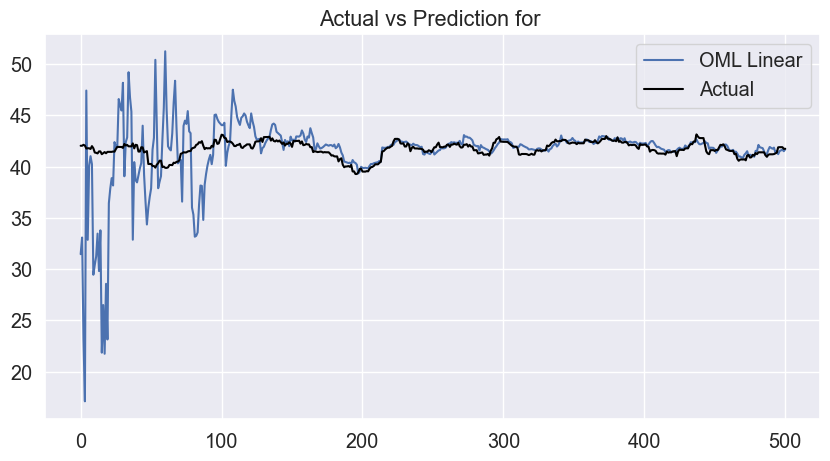

In [39]:
from spotriver.evaluation.eval_bml import (
    plot_bml_oml_horizon_metrics,
    plot_bml_oml_horizon_predictions)
df_labels = ["OML Linear"]
plot_bml_oml_horizon_metrics(
    df_eval,
    df_labels,
    metric=metric)
plot_bml_oml_horizon_predictions(df_preds,
     df_labels,
     target_column=target_column)

### OML Methods (River)

The method `eval-oml-iter-progressive` evaluates one or more OML models on a streaming dataset. The evaluation is done iteratively, and the models are tested at each "step" of the iteration. The results are returned in the form of a dictionary containing metrics and their values.

The method `plot_oml_iter_progressive` visualizes the results based on the dictionary of evaluation results provided by `eval_oml_iter_progressive`. The visualization is inspired by the format used in `river`.
See (Incremental decision trees in river: the Hoeffding Tree case)[https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/].
The following code shows an example application:

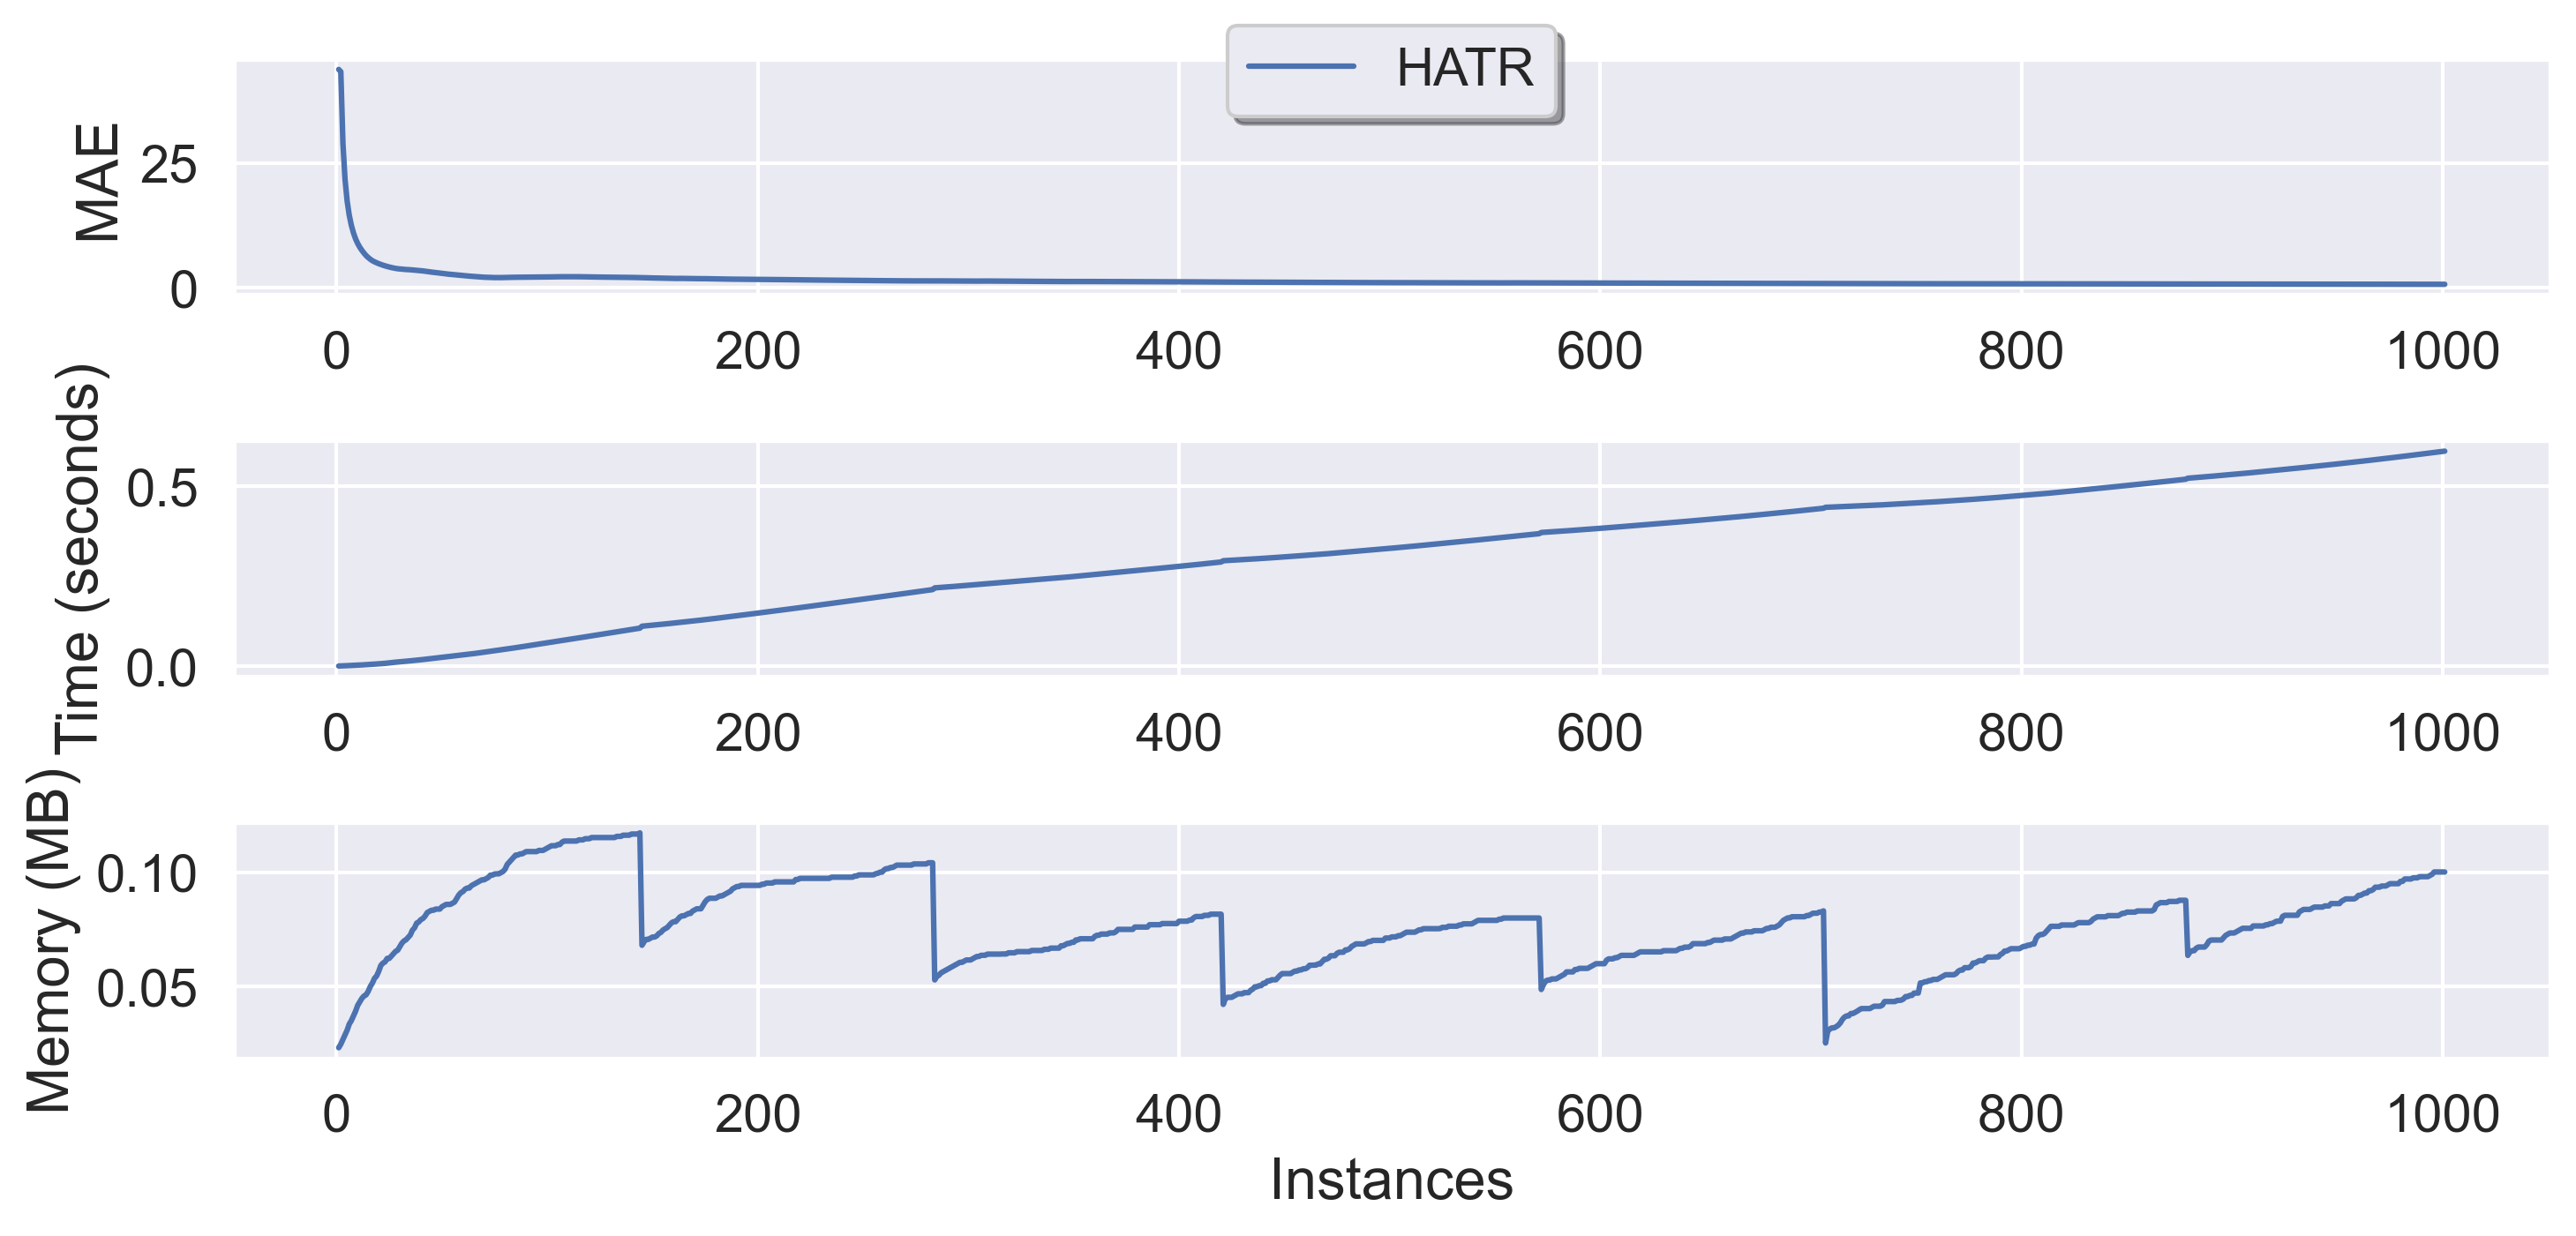

In [40]:
from river import datasets
from spotriver.evaluation.eval_oml import (
    eval_oml_iter_progressive, plot_oml_iter_progressive)
from river import metrics as river_metrics
from river import tree as river_tree
from river import preprocessing as river_preprocessing
dataset = datasets.TrumpApproval()
model = (river_preprocessing.StandardScaler() |
        river_tree.HoeffdingAdaptiveTreeRegressor(seed=1))

res_num = eval_oml_iter_progressive(
    dataset = list(dataset),
    step = 1,
    metric = river_metrics.MAE(),
    models = {"HATR": model})
plot_oml_iter_progressive(res_num)